In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pickle, seaborn as sns
from saspt import RBME, StateArrayDataset

# Initial optimization of saspt analysis parameters for single condition that may have multiple states with 3 replicates aggregated (primary analysis)
paths = pd.read_csv('../data/single-molecule-tracking/experiment_conditions.csv')

settings = dict( # Shared settings
    likelihood_type = RBME,
    pixel_size_um = 0.1,
    frame_interval = 0.033,
    focal_depth = 0.5,
    path_col = 'filepath',
    condition_col = 'condition',
    num_workers = 1, # increasing does not seem to increase speed despite higher CPU use
    progress_bar = True, # doesn't work well with multiple workers
    max_iter = 200, # default 200
    sample_size = 1e9, # fit all data and do not impose any limits with large max sample size
    splitsize = 5
    # diff_coefs=np.logspace(-2.0, 1.0, 100)  # 100 diff coefs from 0.01 to 10.0; this should work to change range
)

max_iter = [40, 200, 1000, 5000, 25000] # test for convergence over wide range of max iterations


SAD = StateArrayDataset.from_kwargs(paths, **settings)

In [4]:
SAD.params.diff_coefs

AttributeError: 'StateArrayParameters' object has no attribute 'diff_coefs'

In [73]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pickle
from saspt import RBME, StateArrayDataset

# parameters
paths = pd.read_csv('../data/single-molecule-tracking/experiment_conditions.csv')
old_file_name = "../data/single-molecule-tracking/SAD_231214.pkl"
new_file_name = "../data/single-molecule-tracking/SAD_240304.pkl"
figure_prefix = '../figures/figure-4/smt-outputs/'
load_file = False
save_file = False

# single file
# paths = paths.iloc[[0]]

settings = dict(
    likelihood_type = RBME,
    pixel_size_um = 0.1,
    frame_interval = 0.033,
    focal_depth = 0.5,
    path_col = 'filepath',
    condition_col = 'condition',
    progress_bar = True,
    max_iter = 500, # default 200
    sample_size = 100000,
    splitsize = 5
    # diff_coefs=np.logspace(-2.0, 1.0, 100)  # 100 diff coefs from 0.01 to 10.0; this should work to change range
)

# load or calculate SAD
if load_file:
    with open(old_file_name, "rb") as file:
        SAD = pickle.load(file)
        SAD.paths = paths # replace with up to date file paths
else:
    SAD = StateArrayDataset.from_kwargs(paths, **settings)
    if save_file:
        with open(new_file_name, "wb") as file:
            pickle.dump(SAD, file)

print(SAD.raw_track_statistics)
print(SAD.params)
print(SAD)

    n_tracks  n_jumps  n_detections  mean_track_length  max_track_length  \
0      24817    68244         93061           3.749889                37   
1      16573    42443         59016           3.560973                82   
2      14926    37966         52892           3.543615                42   
3      13961    35735         49696           3.559630                54   
4      10037    25861         35898           3.576567               123   
5      10195    26609         36804           3.610005               236   
6      13041    36036         49077           3.763285                60   
7      12182    30629         42811           3.514283               200   
8      12300    31110         43410           3.529268               104   
9      13820    34776         48596           3.516353                42   
10     10499    26786         37285           3.551291                44   
11     15405    41192         56597           3.673937                83   
12      7726

In [64]:
marginal_naive_occs = SAD.marginal_naive_occs
marginal_posterior_occs = SAD.marginal_posterior_occs
SAD.posterior_heat_map(figure_prefix + 'posterior_heat_map.png')
SAD.posterior_line_plot(figure_prefix + 'posterior_line_plot.png')
SAD.naive_heat_map(figure_prefix + 'naive_heat_map.png')
SAD.naive_line_plot(figure_prefix + 'naive_line_plot.png')

[########################################] | 100% Completed | 39.00 s
[########################################] | 100% Completed | 20m 43s


In [65]:
# Save marginal occupancy estimates
import pickle
file_name = "../data/single-molecule-tracking/SAD_5_500_marginal_occupancy.pkl"
with open(file_name, "wb") as file:
    pickle.dump([SAD,
                 marginal_naive_occs,
                 marginal_posterior_occs], file)

In [66]:
# Infer posterior occupancies aggregating conditions
posterior_occs, posterior_names = SAD.infer_posterior_by_condition('condition')
print(posterior_occs.shape)
print(posterior_names)

(9, 100)
['PerMn1 FtsBΔLQ mEos3.2', 'PerMn1 FtsBΔLQ mNeonGreen', 'PerMn1 FtsBΔLQΔH mEos3.2', 'PerMn1 FtsBΔLQΔH mNeonGreen', 'PerMn1 uninduced FtsBΔLQ mEos3.2', 'Pf3 FtsBΔLQ mEos3.2', 'Pf3 FtsBΔLQ mNeonGreen', 'Pf3 FtsBΔLQΔH mEos3.2', 'Pf3 FtsBΔLQΔH mNeonGreen']


In [70]:
# Save all occupancy estimates
import pickle
file_name = "../data/single-molecule-tracking/SAD_5_200_all_occupancy.pkl"
    
with open(file_name, "wb") as file:
    pickle.dump([SAD,
                 marginal_naive_occs,
                 marginal_posterior_occs,
                 posterior_occs,
                 posterior_names], file)

In [22]:
# Calculate statistics to report in paper
xlim = [0.02, 1.0]
diff_coefs=SAD.likelihood.diff_coefs
use_coefs = (xlim[0]<=diff_coefs)&(diff_coefs<=xlim[1])
plt_coefs = diff_coefs[use_coefs]

# Table with mean diffusion coefficient for each replicate and for aggregate

# is mean calculated correctly? bins are log spaced... compared the difference...
log_coefs = np.log(plt_coefs)
sample_data = sample_data[use_coefs]
mean_log_coef = np.sum(log_coefs*sample_data)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 42 but corresponding boolean dimension is 100

PerMn1 FtsBΔLQ mEos3.2	0.25950242113997374	0.17190968660637138
PerMn1 FtsBΔLQ mEos3.2	0.13530477745798075	0.15996471351223432
PerMn1 FtsBΔLQ mEos3.2	0.23644894126454083	0.16386844385871566
PerMn1 FtsBΔLQΔH mEos3.2	0.2848035868435802	0.21433831347416216
PerMn1 FtsBΔLQΔH mEos3.2	0.25950242113997374	0.2056778637021224
PerMn1 FtsBΔLQΔH mEos3.2	0.25950242113997374	0.20072965767446324


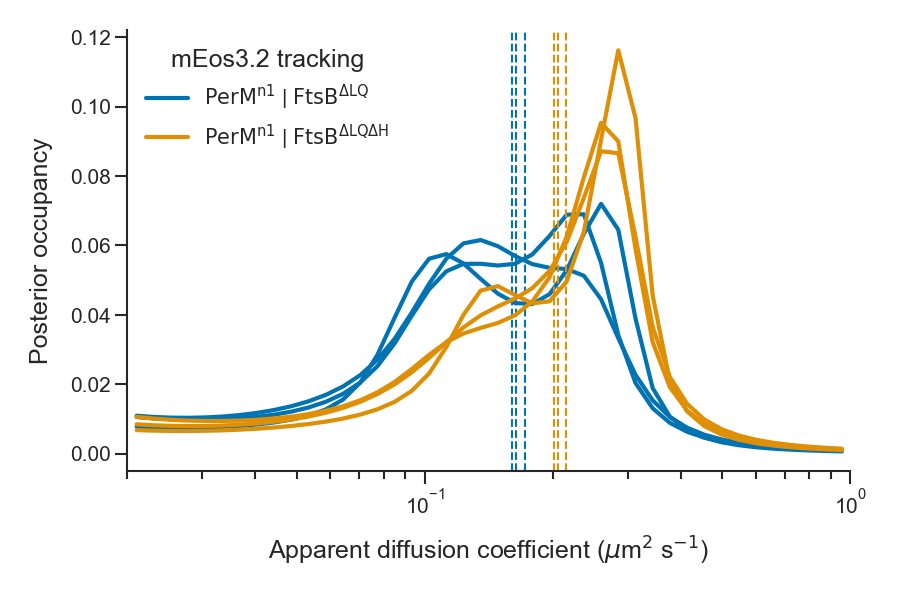

In [71]:
# Figure 4b

import seaborn as sns

sns.set_theme(style='ticks',
              palette=sns.color_palette('colorblind'),
              font='Arial',
              rc={'figure.dpi': 300,
                  'figure.figsize':(7.2,4), # 7.2 inch is full page width
                  'axes.spines.right':False,
                  'axes.spines.top':False,
                  'axes.linewidth':0.5,
                  'font.size':7,
                  'xtick.labelsize':5,
                  'ytick.labelsize':5,
                  'xtick.major.pad':1,
                  'ytick.major.pad':1,
                  'xtick.major.size':3,
                  'ytick.major.size':3,
                  'xtick.minor.size':2,
                  'ytick.minor.size':2,
                  'xtick.major.width':0.5,
                  'ytick.major.width':0.5,
                  'xtick.minor.width':0.5,
                  'ytick.minor.width':0.5,
                  'axes.titlesize':6,
                  'axes.labelsize':6,
                  'legend.fontsize':5,
                  'legend.title_fontsize':6})

xlim = [0.02, 1.0]
ylim = [0,0.11]
plot_cumsum = False
use_n = [0,1]

sep = ' | '
pretty_labels = {'PerMn1 FtsBΔLQ':r'$\text{PerM}^\text{n1}$' + sep + r'$\text{FtsB}^\text{ΔLQ}$',
                'PerMn1 FtsBΔLQΔH':r'$\text{PerM}^\text{n1}$' + sep + r'$\text{FtsB}^\text{ΔLQΔH}$',
                'PerMn1 uninduced FtsBΔLQ':r'$\mathbf{↓}\text{PerM}^\text{n1}$' + sep +  r'$\text{FtsB}^\text{ΔLQ}$',
                'Pf3 FtsBΔLQ':r'$\text{Pf3}$' + sep +  r'$\text{FtsB}^\text{ΔLQ}$',
                'Pf3 FtsBΔLQΔH':r'$\text{Pf3}$' + sep +  r'$\text{FtsB}^\text{ΔLQΔH}$'}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_values = list(pretty_labels.values())
color_dict = {}
for i in range(len(label_values)):
    color_dict[label_values[i]] = colors[i]

dists = {c: SAD.marginal_posterior_occs[df.index,:].copy() \
                for c, df in SAD.paths.groupby(SAD.condition_col)}
diff_coefs=SAD.likelihood.diff_coefs
use_coefs = (xlim[0]<=diff_coefs)&(diff_coefs<=xlim[1])
plt_coefs = diff_coefs[use_coefs]
condition_names = SAD.conditions

fig = plt.figure(figsize=(3,2))

subplt_idx = 0

for n in use_n:

    for i in range(len(dists[condition_names[n]])):
        sample_data = dists[condition_names[n]][i,:]
        sample_data = sample_data[use_coefs]
        normalization = sample_data.sum()
        sample_data = sample_data/normalization
        sample_data = dists[condition_names[n]][i,:]
        sample_data = sample_data[use_coefs]
        normalization = sample_data.sum()
        sample_data = sample_data/normalization
        plot_diff_coefs = diff_coefs[use_coefs]

        label = pretty_labels[' '.join(condition_names[n].split(' ')[:-1])]
        c=color_dict[label]
        if i:
            label = None

        if plot_cumsum:
            plt.plot(plt_coefs,sample_data.cumsum(),c=c,label=label,linewidth=1)
        else:
            plt.plot(plt_coefs,sample_data,c=c,label=label,linewidth=1)

        plt.axvline(np.sum(plt_coefs*sample_data),color=c,linestyle='--',linewidth=0.5)
        plt.legend(frameon=False,title='mEos3.2 tracking')
                
        print(condition_names[n],plot_diff_coefs[sample_data.argmax()], np.sum(plot_diff_coefs*sample_data),sep='\t')
    
plt.xscale('log')   

plt.xlabel(r'Apparent diffusion coefficient ($\mu$m$^{2}$ s$^{-1}$)')
plt.ylabel('Posterior occupancy')
plt.xlim(xlim)
# plt.ylim(ylim)
plt.tight_layout()
plt.savefig(figure_prefix + 'replicates_helix_effect.png',dpi=300)
plt.savefig(figure_prefix + 'replicates_helix_effect.svg',dpi=300)

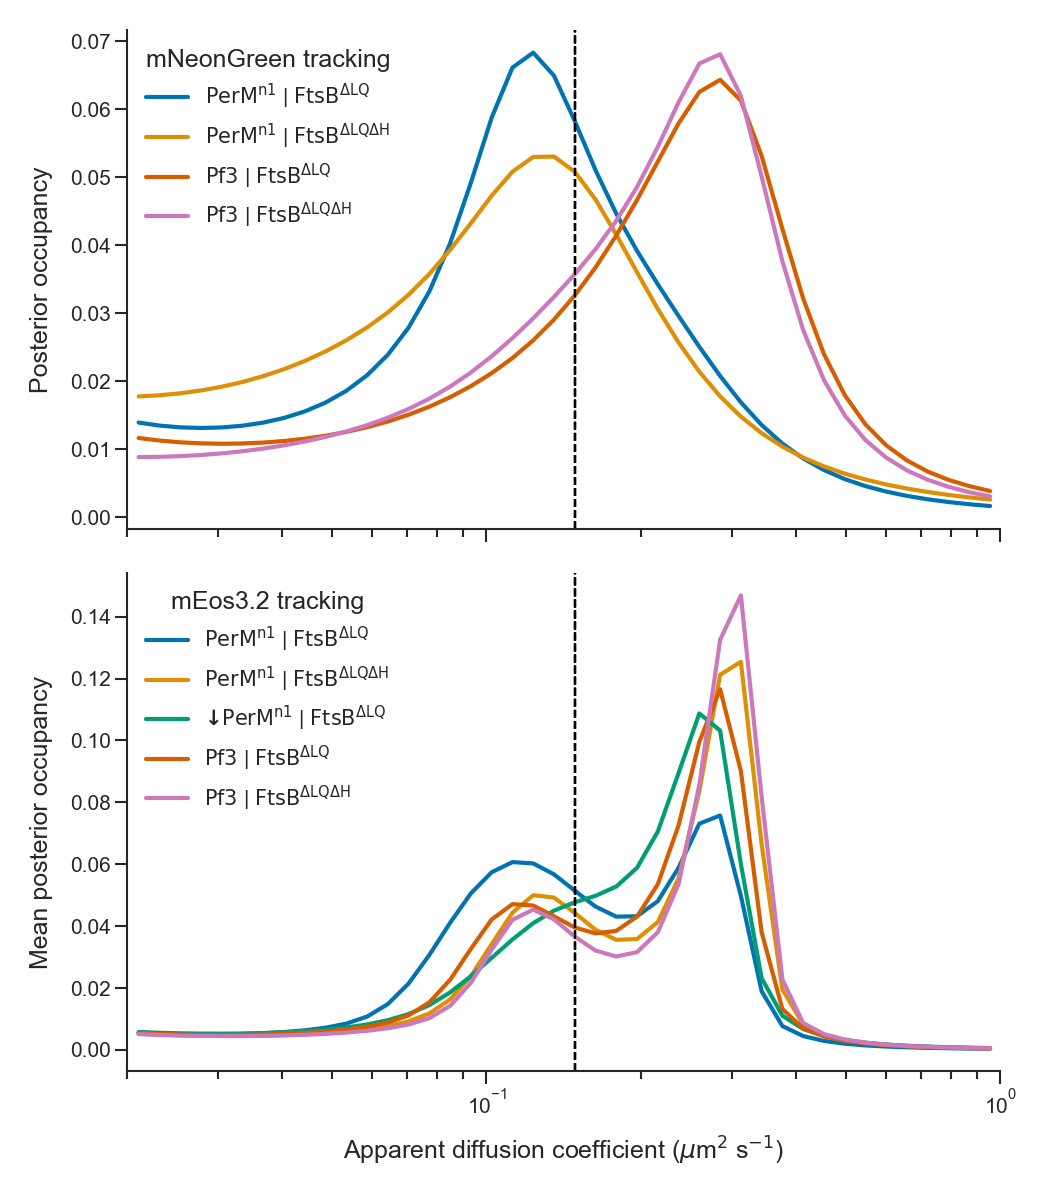

In [72]:
# Normalize and plot together Fig 4c

from saspt import normalize_2d

# exclude very close to zero to reduce noise and improve normalization
use_occs = posterior_occs[:,use_coefs]
use_occs = normalize_2d(use_occs, axis=1)
mean_PerM_coef = np.sum(plt_coefs * use_occs[1,:])

fig,ax = plt.subplots(2,1,sharex=True,sharey=False,figsize=(3.5,4))

for c in range(use_occs.shape[0]):

    label = pretty_labels[' '.join(posterior_names[c].split(' ')[:-1])]

    if 'mNeonGreen' in posterior_names[c]:
        ax[0].plot(plt_coefs, use_occs[c,:], label=label,linewidth=1,c=color_dict[label])
        ax[0].set(ylabel='mNeonGreen')
        ax[0].legend(frameon=False,title='mNeonGreen tracking')
    else:
        ax[1].plot(plt_coefs, use_occs[c,:], label=label,linewidth=1,c=color_dict[label])
        ax[1].set(ylabel='mEos3.2')
        ax[1].legend(frameon=False,title='mEos3.2 tracking')
    
    ax[0].axvline(mean_PerM_coef,c='k',linestyle='--',linewidth=0.5)
    ax[1].axvline(mean_PerM_coef,c='k',linestyle='--',linewidth=0.5)
    ax[0].set_ylabel('Posterior occupancy')
    ax[1].set_ylabel('Mean posterior occupancy')
    plt.xscale('log')
    plt.xlim(xlim)

plt.xlabel(r'Apparent diffusion coefficient ($\mu$m$^{2}$ s$^{-1}$)')
plt.tight_layout()
plt.savefig(figure_prefix + 'mNeonGreen_mEos32_diffusion.png',dpi=300)
plt.savefig(figure_prefix + 'mNeonGreen_mEos32_diffusion.svg',dpi=300)
plt.show()

In [9]:
# Save several variables
import pickle
file_name = "../data/single-molecule-tracking/SAD_240304.pkl.dontoverwrite"
with open(file_name, "wb") as file:
    pickle.dump([SAD,
                 marginal_naive_occs,
                 marginal_posterior_occs,
                 posterior_occs,
                 posterior_names], file)

In [11]:
# load variables
import pickle
file_name = "../data/single-molecule-tracking/SAD_240304.pkl"
with open(file_name, 'rb') as f:
    SAD,marginal_naive_occs,marginal_posterior_occs,posterior_occs,posterior_names = pickle.load(f)